Import libraries 

In [5]:
import pandas as pd
import numpy as np
import gc
import joblib
import time
import lightgbm
import matplotlib.pyplot as plt
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, plot_importance
from sklearn.linear_model import LogisticRegression,LinearRegression


Read data

In [6]:
sales = pd.read_csv('./data/sales_train.csv')
shops = pd.read_csv('./data/shops.csv')
items = pd.read_csv('./data/items.csv')
item_cats = pd.read_csv('./data/item_categories.csv')
test = pd.read_csv('./data/test.csv').set_index('ID')
submissions = pd.read_csv('./data/sample_submission.csv')

# sales = sales[sales['shop_id'].isin([25, 27, 30, 31])]
# test = test[test['shop_id'].isin([25, 27, 30, 31])]

Exploring data
Looking for outliers

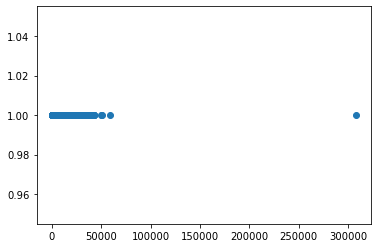

In [7]:
plt.scatter(x=sales['item_price'], y=np.ones(sales['item_price'].count()))   
plt.show()

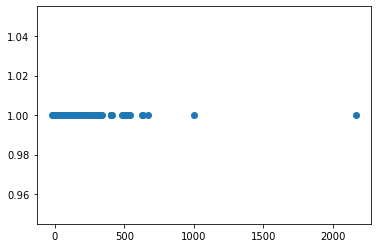

In [8]:
plt.scatter(x=sales['item_cnt_day'], y=np.ones(sales['item_price'].count()))   
plt.show()

Remove items with price higher that 40000 and items with sales more than 400 per day

In [9]:
sales = sales[sales['item_price'] < 40000]
sales = sales[sales['item_cnt_day'] < 400]
sales['item_cnt_day'] = sales['item_cnt_day'].clip(0, 20)

Preprocessing shops
Fix some shops name and LabelEncode city names to city_code

In [10]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id', 'city_code']]

Creating all pairs of shop_id and item_id from train data, so its deviation would be more like in test set
For that create product of shops and items for each date_block_num

In [11]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items], [block_num])), dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns=index_cols)


Preprocessing test data and merge train and test sets

In [12]:
test['date_block_num'] = 34
grid = pd.concat([grid, test], ignore_index=True, sort=False, keys=index_cols)
grid.fillna(0, inplace=True)


Creating new column revenue - amount money for each item per day

In [13]:
sales['revenue'] = sales['item_cnt_day']*sales['item_price']

In [14]:
# group by data to get shop-item-date_block_num aggregates
gb = sales.groupby(by=index_cols, as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target'})
gb['target'] = gb['target'].clip(0, 20)
# gb = gb.clip(0, 20)
data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

In [15]:
# group by data to get shop-date_block_num aggregates
gb = sales.groupby(by=['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_shop'})
data = pd.merge(data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)


In [16]:
# group by data to get item-date_block_num aggregates
gb = sales.groupby(by=['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_item'})
data = pd.merge(data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)


# group by data to get shop-date_block_num-month revenue
gb = sales.groupby(by=index_cols, as_index=False)['revenue'].sum()
gb = gb.rename(columns={'revenue': 'revenue_shop_item'})
data = pd.merge(data, gb, how='left', on=index_cols).fillna(0)


# group by data to get shop-date_block_num-revenue
gb = sales.groupby(by=['shop_id', 'date_block_num'], as_index=False)['revenue'].sum()
gb = gb.rename(columns={'revenue': 'revenue_shop'})
data = pd.merge(data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# group by data to get item-date_block_num-revenue
gb = sales.groupby(by=['item_id', 'date_block_num'], as_index=False)['revenue'].sum()
gb = gb.rename(columns={'revenue': 'revenue_item'})
data = pd.merge(data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)



In [17]:
# group by data to get item-date_block_num-average
gb = sales.groupby(by=['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].mean()
gb = gb.rename(columns={'item_cnt_day': 'item_avg_month'})
data = pd.merge(data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)
# group by data to get shop-date_block_num-average
gb = sales.groupby(by=['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].mean()
gb = gb.rename(columns={'item_cnt_day': 'shop_avg_month'})
data = pd.merge(data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

Mapping item_category_id

In [18]:
data = pd.merge(data, items[['item_id', 'item_category_id']], how='left', on=['item_id']).fillna(0)
sales = pd.merge(sales, items[['item_id', 'item_category_id']], how='left', on=['item_id']).fillna(0)


In [19]:
# group by data to get category-date_block_num-average
gb = sales.groupby(by=['item_category_id', 'date_block_num'], as_index=False)['item_cnt_day'].mean()
gb = gb.rename(columns={'item_cnt_day': 'cat_item_avg'})
data = pd.merge(data, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)

Adding new features like number of month and days in each month

In [20]:
data['month'] = data['date_block_num'] % 12 + 1
sales['month'] = sales['date_block_num'] % 12 + 1
days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
data['days'] = data['month'].map(days)


In [21]:
# group by data to get category-month-average
gb = sales.groupby(by=['item_category_id', 'month'], as_index=False)['item_cnt_day'].mean()
gb = gb.rename(columns={'item_cnt_day': 'cat_item_month_avg'})
data = pd.merge(data, gb, how='left', on=['item_category_id', 'month']).fillna(0)
# group by data to get shop-month-average
gb = sales.groupby(by=['shop_id', 'month'], as_index=False)['item_cnt_day'].mean()
gb = gb.rename(columns={'item_cnt_day': 'shop_month_avg'})
data = pd.merge(data, gb, how='left', on=['shop_id', 'month']).fillna(0)
# group by data to get item-category-month-average
gb = sales.groupby(by=['item_category_id', 'shop_id', 'month'], as_index=False)['item_cnt_day'].mean()
gb = gb.rename(columns={'item_cnt_day': 'shop_cat_item_month_avg'})
data = pd.merge(data, gb, how='left', on=['item_category_id', 'shop_id', 'month']).fillna(0)

Creating lags for specified features

In [24]:
ts = time.time()
cols_to_rename = ['target', 'target_shop', 'target_item', 'revenue_shop_item', 'revenue_shop', 
                  'revenue_item', 'cat_item_avg', 'item_avg_month', 'shop_avg_month',
                  'cat_item_month_avg', 'shop_month_avg', 'shop_cat_item_month_avg']

shift_range = [1, 2, 3, 6, 12]

for month_shift in shift_range:
    train_shift = data[index_cols+cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    train_shift = train_shift.rename(columns=(lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x))
    data = pd.merge(data, train_shift, on=index_cols, how='left').fillna(0)
print(time.time()-ts)


295.4332151412964


Join data to get city_code for each shop

In [25]:
data = data.merge(shops, on=['shop_id'], how='left')

Change types, so data takes less space

In [26]:
for column in data.columns:
    if data[column].dtype == 'int64':
        data[column] = data[column].astype('int32')
    if data[column].dtype == 'float64':
        data[column] = data[column].astype('float32')

Adding feature - first time when item was sold

In [27]:
gb = sales.groupby(by=['item_id'], as_index=False)['date_block_num'].min()
gb = gb.rename(columns={'date_block_num': 'first_item_sale_date_block'})
data = pd.merge(data, gb, how='left', on=['item_id']).fillna(34)

Specify columns to remove, because we can't use data which we don't have for test set

In [28]:
to_drop_cols = ['date_block_num', 'target', 'target_shop', 'target_item', 
                'revenue_shop_item', 'revenue_item', 'revenue_shop',
                'item_avg_month', 'cat_item_avg', 'shop_avg_month',
                'cat_item_month_avg', 'shop_month_avg', 'shop_cat_item_month_avg']


Saving dates, because we need them to split data, but can't use as feature

In [29]:
dates = data['date_block_num']
last_block = dates.max()

Split data for train, test and validation

In [30]:
dates_train = dates[dates < last_block]
dates_test = dates[dates == last_block]

x_train = data.loc[dates < last_block-1].drop(to_drop_cols, axis=1)
x_valid = data.loc[dates == last_block-1].drop(to_drop_cols, axis=1)
x_test = data.loc[dates == last_block].drop(to_drop_cols, axis=1)


y_train = data.loc[dates < last_block-1, 'target']
y_valid = data.loc[dates == last_block-1, 'target']



In [31]:
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10675438 entries, 0 to 10675437
Data columns (total 67 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   shop_id                         int32  
 1   item_id                         int32  
 2   item_category_id                int32  
 3   month                           int32  
 4   days                            float32
 5   target_lag_1                    float32
 6   target_shop_lag_1               float32
 7   target_item_lag_1               float32
 8   revenue_shop_item_lag_1         float32
 9   revenue_shop_lag_1              float32
 10  revenue_item_lag_1              float32
 11  cat_item_avg_lag_1              float32
 12  item_avg_month_lag_1            float32
 13  shop_avg_month_lag_1            float32
 14  cat_item_month_avg_lag_1        float32
 15  shop_month_avg_lag_1            float32
 16  shop_cat_item_month_avg_lag_1   float32
 17  target_lag_2             

Saving created data to disk

In [32]:
ts = time.time()
x_train.to_csv('./data/created/x_train.csv', index=False)
y_train.to_csv('./data/created/y_train.csv', index=False)

x_valid.to_csv('./data/created/x_valid.csv', index=False)
y_valid.to_csv('./data/created/y_valid.csv', index=False)

x_test.to_csv('./data/created/x_test.csv', index=False)
del data
gc.collect()
print(time.time()-ts)


556.0781686306


Read data from disk if need (in case we restart notebook/app and don't wanna spend time for recreating features)

In [33]:
x_train = pd.read_csv('./data/created/x_train.csv')
y_train = pd.read_csv('./data/created/y_train.csv')

x_valid = pd.read_csv('./data/created/x_valid.csv')
y_valid = pd.read_csv('./data/created/y_valid.csv')

x_test = pd.read_csv('./data/created/x_test.csv')

Specify parameteres for model and train it, for tunning parameters was used early stopping

In [ ]:
ts = time.time()
xgb = XGBRegressor(
    max_depth=8,
    n_estimators=250,
    min_child_weight=2**7,
    colsample_bytree=0.8,
    subsample=0.75,
    eta=0.2,
    tree_method='hist',
    numthreads=8,
    grow_police='lossguide',
    predictor='cpu_predictor',
    rate_drop=0.2
)
xgb.fit(x_train, y_train,
        eval_metric='rmse', eval_set=[(x_valid, y_valid)],
        verbose=True, early_stopping_rounds=10)
print(time.time()-ts)

After finding best parameters concatanete train and validation data and train model with this data

In [ ]:
x_train = pd.concat([x_train, x_valid], ignore_index=True, sort=False)
y_train = pd.concat([y_train, y_valid], ignore_index=True, sort=False)


In [ ]:
ts = time.time()
xgb = XGBRegressor(
    max_depth=10,
    n_estimators=31,
    min_child_weight=2**7,
    colsample_bytree=0.8,
    subsample=0.75,
    eta=0.2,
    tree_method='hist',
    numthreads=8,
    grow_police='lossguide',
    predictor='cpu_predictor',
    rate_drop=0.2
)
xgb.fit(x_train, y_train)
print(time.time()-ts)

Predict data for test set, clip it accordding to competition rules and save it as csv file

In [59]:
pred_xgb = xgb.predict(x_test).clip(0, 20)
valid_xgb = xgb.predict(x_valid).clip(0,20)

In [45]:
submissions = pd.DataFrame({
    'ID': x_test.index - x_test.index.min(),
    'item_cnt_month': pred_xgb
})
submissions.to_csv('submissions.csv', index=False)

Display feature importance

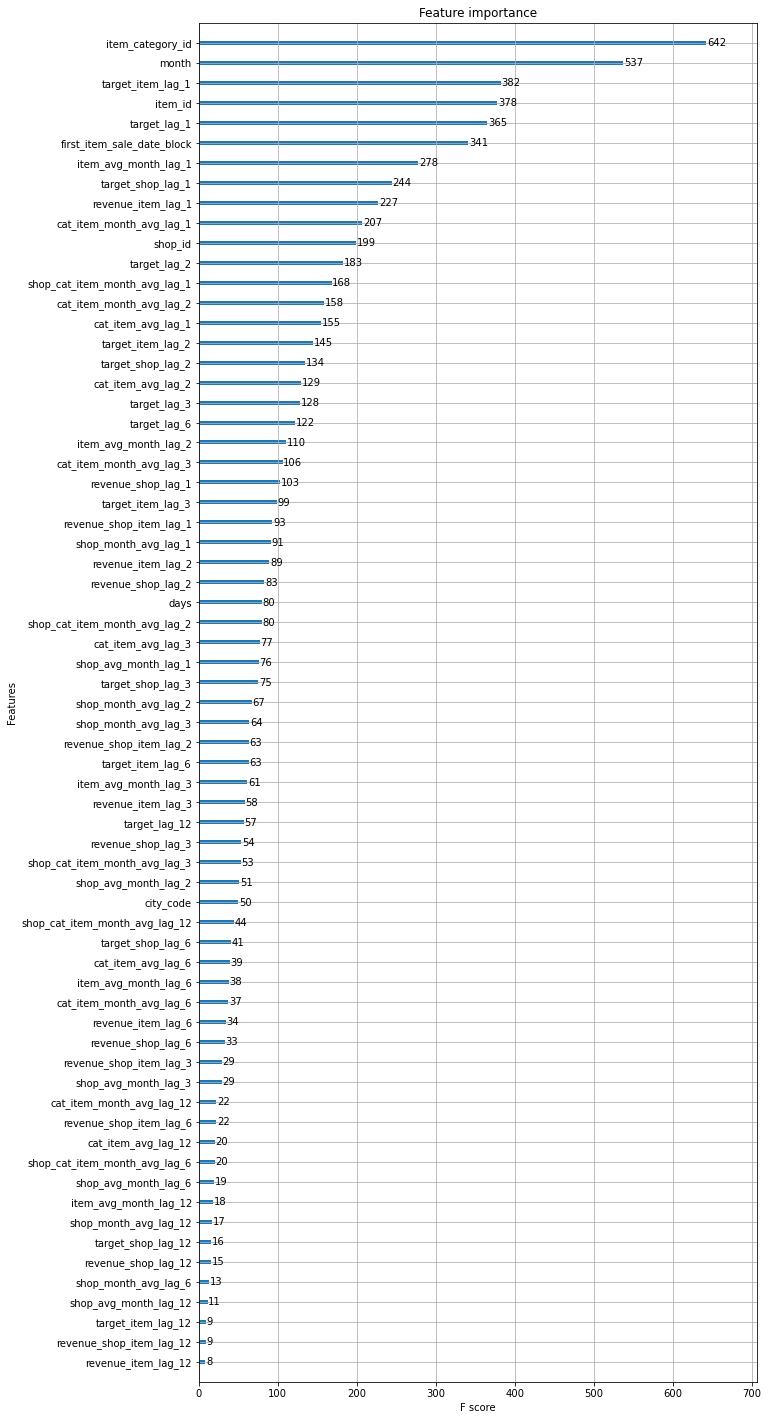

In [46]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)


plot_features(xgb, (10, 25))
plt.show()


Creating LightGBM model, also using early stopping for tunning

In [73]:
lgb_params = {
    'feature_fraction': 0.6,
    'metric': 'rmse',
    'min_data_in_leaf': 2**6,
    'bagging_fraction': 0.75,
    'learning_rate': 0.05,
    'objective': 'rmse',
    'bagging_seed': 2**7,
    'num_leaves': 2**8,
    'tree_learner': 'feature',
    'bagging_freq': 1,
    'verbose': 0,
    'n_jobs': 8,
}


In [74]:
lgbm = lightgbm.train(lgb_params, lightgbm.Dataset(x_train, label=y_train), num_boost_round=190,
                      valid_sets=lightgbm.Dataset(x_valid, label=y_valid), early_stopping_rounds=10)


[1]	valid_0's rmse: 1.11985
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 1.10527
[3]	valid_0's rmse: 1.08987
[4]	valid_0's rmse: 1.07367
[5]	valid_0's rmse: 1.06143
[6]	valid_0's rmse: 1.04899
[7]	valid_0's rmse: 1.03666
[8]	valid_0's rmse: 1.02732
[9]	valid_0's rmse: 1.01666
[10]	valid_0's rmse: 1.00881
[11]	valid_0's rmse: 0.999611
[12]	valid_0's rmse: 0.992228
[13]	valid_0's rmse: 0.986332
[14]	valid_0's rmse: 0.980807
[15]	valid_0's rmse: 0.975775
[16]	valid_0's rmse: 0.971406
[17]	valid_0's rmse: 0.966808
[18]	valid_0's rmse: 0.962774
[19]	valid_0's rmse: 0.958762
[20]	valid_0's rmse: 0.955448
[21]	valid_0's rmse: 0.954152
[22]	valid_0's rmse: 0.952321
[23]	valid_0's rmse: 0.949838
[24]	valid_0's rmse: 0.948253
[25]	valid_0's rmse: 0.94614
[26]	valid_0's rmse: 0.943879
[27]	valid_0's rmse: 0.942485
[28]	valid_0's rmse: 0.940756
[29]	valid_0's rmse: 0.940735
[30]	valid_0's rmse: 0.940398
[31]	valid_0's rmse: 0.938867
[32]	valid_0's rmse: 0.937698

In [75]:
pred_lgb = lgbm.predict(x_test).clip(0, 20)
valid_lgbm = lgbm.predict(x_valid).clip(0, 20)

In [ ]:
submissions = pd.DataFrame({
    'ID': x_test.index - x_test.index.min(),
    'item_cnt_month': pred_lgb
})

Creating linear model for model-types variance

In [50]:
lr=LinearRegression()
lr.fit(x_train.values, y_train.values)
lr_preds = lr.predict(x_test.values).clip(0, 20)
valid_lr = lr.predict(x_valid).clip(0,20)

Save models to disk, so we can use it without retraining

In [76]:
joblib.dump(xgb,'xgboost_model.dat')
joblib.dump(lgbm,'lightgbm_model.dat')
joblib.dump(lr,'linear_model.dat')

['linear_model.dat']

Finding best weights for data, using just bruteforce

In [77]:
best_l = 0
best_lg = 0
best_x = 0
best_mse = 100

x_valid_2 = np.c_[valid_lr, valid_xgb, valid_lgbm]
x_test_level2 = np.c_[lr_preds, pred_xgb, pred_lgb]


In [78]:
print(mean_squared_error(y_valid, valid_lgbm, squared=False))
print(mean_squared_error(y_valid, valid_xgb, squared=False))
print(mean_squared_error(y_valid, valid_lr, squared=False))

0.932187727821433
0.9311716098002499
0.9666766607879239


In [79]:
for l in np.arange(0, 1, 0.01):
    for x in np.arange(0, 1-l, 0.01):
        lg=1-x-l
        mix = l * x_valid_2[:, 0] + x * x_valid_2[:, 1] + lg * x_valid_2[:, 2]
        mse = mean_squared_error(y_valid, mix, squared=False)
        if mse < best_mse:
            best_mse = mse
            best_l = l
            best_lg = lg
            best_x = x
            print('mse={3}\n,linear={0}\nxgboost={1}\nlightgbm={2}\n'.format(best_l, best_x, best_lg, mse))


mse=0.932187727821433
,linear=0.0
xgboost=0.0
lightgbm=1.0

mse=0.9319649236532943
,linear=0.0
xgboost=0.01
lightgbm=0.99

mse=0.9317463636433165
,linear=0.0
xgboost=0.02
lightgbm=0.98

mse=0.9315320507788464
,linear=0.0
xgboost=0.03
lightgbm=0.97

mse=0.9313219879919039
,linear=0.0
xgboost=0.04
lightgbm=0.96

mse=0.9311161781589814
,linear=0.0
xgboost=0.05
lightgbm=0.95

mse=0.9309146241008527
,linear=0.0
xgboost=0.06
lightgbm=0.94

mse=0.9307173285823807
,linear=0.0
xgboost=0.07
lightgbm=0.9299999999999999

mse=0.9305242943123317
,linear=0.0
xgboost=0.08
lightgbm=0.92

mse=0.9303355239431901
,linear=0.0
xgboost=0.09
lightgbm=0.91

mse=0.9301510200709802
,linear=0.0
xgboost=0.1
lightgbm=0.9

mse=0.9299707852350889
,linear=0.0
xgboost=0.11
lightgbm=0.89

mse=0.9297948219180932
,linear=0.0
xgboost=0.12
lightgbm=0.88

mse=0.9296231325455907
,linear=0.0
xgboost=0.13
lightgbm=0.87

mse=0.929455719486035
,linear=0.0
xgboost=0.14
lightgbm=0.86

mse=0.9292925850505733
,linear=0.0
xgboost=0.15

mse=0.9246059125998725
,linear=0.07
xgboost=0.42
lightgbm=0.51

mse=0.9245653882036364
,linear=0.07
xgboost=0.43
lightgbm=0.5

mse=0.9245291930149565
,linear=0.07
xgboost=0.44
lightgbm=0.49000000000000005

mse=0.9244973275423138
,linear=0.07
xgboost=0.45
lightgbm=0.48000000000000004

mse=0.9244697922334303
,linear=0.07
xgboost=0.46
lightgbm=0.47000000000000003

mse=0.9244465874752369
,linear=0.07
xgboost=0.47000000000000003
lightgbm=0.46

mse=0.9244277135938472
,linear=0.07
xgboost=0.48
lightgbm=0.45

mse=0.9244131708545333
,linear=0.07
xgboost=0.49
lightgbm=0.44

mse=0.9244029594617087
,linear=0.07
xgboost=0.5
lightgbm=0.43

mse=0.9243970795589119
,linear=0.07
xgboost=0.51
lightgbm=0.42

mse=0.9243955312287991
,linear=0.07
xgboost=0.52
lightgbm=0.41

mse=0.9243883367507548
,linear=0.08
xgboost=0.42
lightgbm=0.5000000000000001

mse=0.9243481164773178
,linear=0.08
xgboost=0.43
lightgbm=0.49000000000000005

mse=0.9243122264542172
,linear=0.08
xgboost=0.44
lightgbm=0.48000000000000004

ms

mse=0.9226731380833754
,linear=0.21
xgboost=0.47000000000000003
lightgbm=0.32000000000000006

mse=0.9226586272366023
,linear=0.21
xgboost=0.48
lightgbm=0.31000000000000005

mse=0.922648455973827
,linear=0.21
xgboost=0.49
lightgbm=0.30000000000000004

mse=0.9226426244385691
,linear=0.21
xgboost=0.5
lightgbm=0.29000000000000004

mse=0.9226411327131161
,linear=0.21
xgboost=0.51
lightgbm=0.28

mse=0.9226355727130858
,linear=0.22
xgboost=0.48
lightgbm=0.30000000000000004

mse=0.922625715443267
,linear=0.22
xgboost=0.49
lightgbm=0.29000000000000004

mse=0.9226201980132696
,linear=0.22
xgboost=0.5
lightgbm=0.28

mse=0.9226190205009523
,linear=0.22
xgboost=0.51
lightgbm=0.27

mse=0.922616765776848
,linear=0.23
xgboost=0.49
lightgbm=0.28

mse=0.9226115625452653
,linear=0.23
xgboost=0.5
lightgbm=0.27

mse=0.9226106992741571
,linear=0.23
xgboost=0.51
lightgbm=0.26



Creating test predictions using different models with weights and save it to disk

In [80]:
test_preds = best_l*x_test_level2[:, 0] + best_x * x_test_level2[:, 1] + best_lg * x_test_level2[:, 2]

submissions_enseble = pd.DataFrame({
    'ID': range(len(test_preds)),
    'item_cnt_month': test_preds
})

submissions_enseble.to_csv('submission_ensemble.csv', index=False)

Done, with this code, I achive public score: 0.916958 and  private score: 0.914670.